# Julia for Economists
## Computational Bayesian Statistics
### Cameron Pfiffer (cpfiffer@stanford.edu)

### Howdy

- I'm Cameron Pfiffer, a finance PhD student at the University of Oregon.
- Visiting here at Stanford
- This is the 5th in a series of Julia bootcamps for computational economics
- Please interrupt me when questions arise
- Today is two 1-hour sections, 10 minute break in the middle, some practice questions


### The topic for today? Bayesian statistics!

- The basics of Bayes rule
- Conjugate priors
- Probabilistic programming with Julia
- This is my favorite topic! Come at me, gang

# Bayes' rule

Bayes' rule is a statistical identity. Suppose we have a model with _parameters_ $\theta$ and _data_ $X$. 

Both $\theta$ and $X$ are probabilistic -- we don't know $\theta$ necessarily, and we believe $X$ is drawn randomly from a distribution parameterized by $\theta$.

Once we have the data in hand, we can have a better understanding about the types of values of $\theta$ that might have generated our data $X$.

Bayes' rule formalizes this for us, with the relationship

$$
P(\theta \mid X) = \frac{P(X \mid \theta) P(\theta) }{P(X)}
$$

where 

- $P(X \mid \theta)$ is the __likelihood__
- $P(\theta)$ is the __prior__
- $P(X)$ is the __normalizing constant__
- $P(\theta \mid X)$ is the __posterior__

The advantage of having the posterior $P(\theta \mid X)$ is that we can make predictions or understand our data better once we have this posterior.

For example, suppose we wanted to predict a new data point $x'$. This is as simple as drawing random values from the distribution $P(x' \mid \theta, X)$!

__Side note__: A lot of conventionally frequentist methods (like OLS) are a subset of Bayesian methods with uniform priors! You're already a Bayesian, welcome to the cult!

### An example: detecting a biased coin

Suppose we're playing a game with our very annoying friend, who tends to cheat. The friend wants to just keep flipping a coin for hours and hours. 

We are graduate students and writing a dissertation sucks, so we agree to play.

Unfortunately, our friend has acquired a trick coin, where the probability of heads may _not_ be 50%.

Enter Bayes' rule!

We're going to try to quantify _how uncertain_ we are about the true probability of the coin flip!

Let's start by defining priors on our friend's coin. A good prior is a Beta distribution, which is defined for values between 0 and 1.

The Beta distribution has two parameters $(\alpha, \beta)$ and has the PDF

$$
P(x \mid \alpha, \beta) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha, \beta)}
$$

where 

$$
B(\alpha, \beta) = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)}
$$

and $\Gamma(\cdot)$ is the Gamma function.

Here's a little example of what the PDF of the Beta looks like!

In [ ]:
using Distributions, StatsPlots

params = [
    (1, 1),
    (3, 1),
    (3, 6),
    (10,10)
]

ps = plot()
for (alpha, beta) in params
    plot!(ps, Beta(alpha, beta), label="α=$alpha, β=$beta")
end

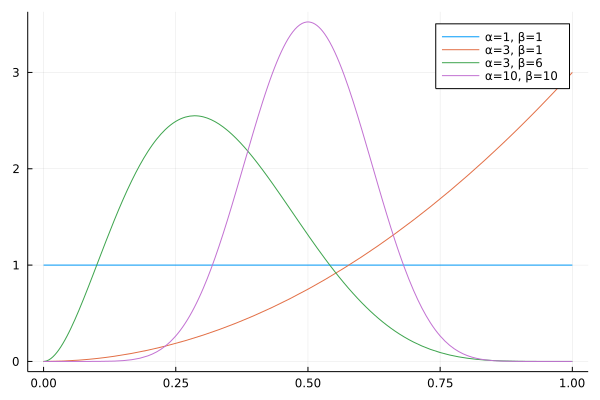

In [12]:
display(ps)

We'll use the Beta distribution as our prior. Let's pick $(\alpha, \beta)$ such that we believe that the coin flip is fair _on average_, meaning $E[\text{Beta}(\alpha, \beta)] = 0.5$.

This happens when $\alpha = \beta$. The higher we set $\alpha = \beta$, the more confident we are that the coin is fair.

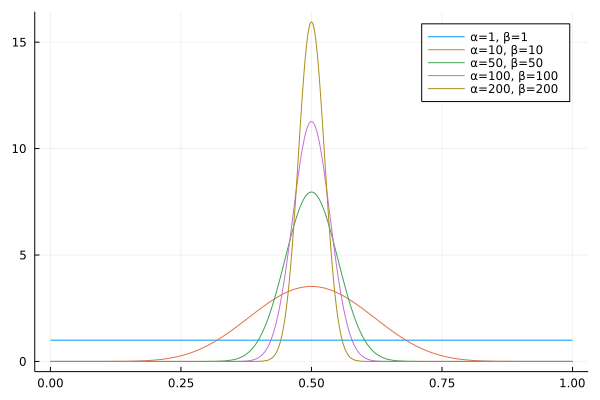

In [19]:
ps = plot()
for i in [1, 10, 50, 100, 200]
    plot!(ps, Beta(i, i), label="α=$i, β=$i")
end
ps

I'll pick the prior that $\alpha = \beta = 10$, because I think it's _really_ unlikely that our friend was able to find a coin that reliably shows heads more than 75% or  less than 25% of the time. 

It's physcially hard to make a coin _that_ unfair!



### The likelihood

We now have our prior over the probability that the coin shows heads on a single flip. 

Next, we need a likelihood, the thing that determines how likely an observed result is given our parameters.

There's two good fits for a coin flip game:

- The Bernoulli distribution, which has a single parameter (probability of a success) and represents a single trial.
- The Binomial distribution, which has a single parameter (probability of success) and represents one or more trials. 

The Binomial distribution is essentially a multi-trial version of the Bernoulli.

We'll be observing multiple flips from our friend, so the Binomial is a better fit.

The Binomial mass function is

$$
P(n,k \mid p) = \binom{n}{k} p^k (1-p)^{n-k}
$$

for 

- Success probability $p$ (this is a parameter)
- Number of trials/coin flips $n$
- Number of successes/heads $k$

### Conjugate priors

I've carefully set up this model (a Beta prior and a Binomial likelihood) because the Beta is what is referred to as a __conjugate prior__ to the Binomial likelihood.

A conjugate prior is __amazing__ because there is an analytic form for the posterior $P(\theta \mid X)$! 

We'll talk more later about how not having a conjugate prior is fine, but a little slower to compute.

Formally, if a prior distribution $P(\theta)$ is in the sample distributional family as the posterior $P(\theta \mid X)$, then the prior and the posterior are conjugate.

There are lists of conjugate distributions

- On [Wikipedia](https://en.wikipedia.org/wiki/Conjugate_prior)
- DeGroot's [Optimal Statistical Decisions](https://www.amazon.com/dp/047168029X/ref=sspa_dk_detail_1?psc=1p13NParams&spLa=ZW5jcnlwdGVkUXVhbGlmaWVyPUEyWFlJUkpFSFZSS1VWJmVuY3J5cHRlZElkPUEwMjUyNDUwMTRENlo2R1BPUkFTWCZlbmNyeXB0ZWRBZElkPUEwNzIwMDIzM1IyTlJKOUhaVTRYSCZ3aWRnZXROYW1lPXNwX2RldGFpbDImYWN0aW9uPWNsaWNrUmVkaXJlY3QmZG9Ob3RMb2dDbGljaz10cnVl)
- Kevin Murphy's [Machine Learning: A Probabilistic Perspective](https://mitpress.mit.edu/books/machine-learning-1) and [Probabilistic Machine Learning: An Introduction](https://mitpress.mit.edu/books/probabilistic-machine-learning)


Sometimes it's worth framing your problem in a way to find conjugacy because it is fast as heck to compute.

I'm not going to walk through how you analytically find whether your distribution is analytic -- that is a math class. Go do a math class. Or be lazy and Google to see whether someone's already done the math.

We use computers here because math is hard.

### The posterior

With a 

- Beta prior on heads probability $p$ and hyperparameters $(\alpha_0, \beta_0)$
- Binomial likelihood for observed flips $x$, where $x_i \in \{0, 1\}$

the posterior distribution is 

$$
p \mid x \sim \text{Beta}\bigg(\alpha_0 + \sum x_i, \beta_0 + \sum (N - x_i) \bigg)
$$

$\alpha$ is interpretable as the number of __successes__, and $\beta$ is the number of __failures__.

Alrighty! Let's code this up. 

First, I'm going to generate the data. I'm going to pretend that my friend has a coin where the heads probability is actually 0.45.

Let's pretend we flip the coin 10 times (our dissertations are being heavily neglected). 

In [56]:
# True heads probability
true_prob = 0.45

# Draw a bunch of coin flips
n_draws = 10
data = rand(Binomial(1, true_prob), n_draws); # Since n=1 here, this is technically a Bernoulli!

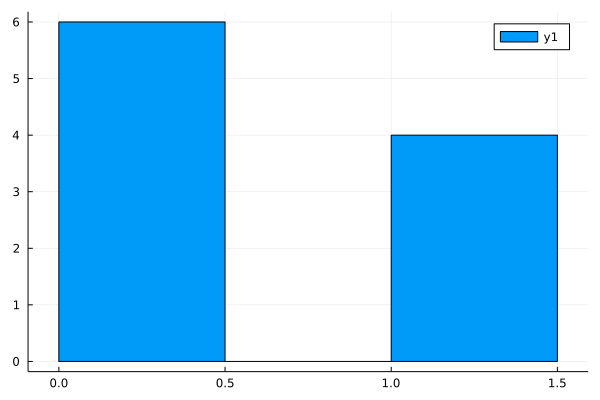

In [57]:
# Let's look at our data
histogram(data)

In [58]:
# Prior parameters
α0 = β0 = 10

# Posterior density function
function posterior_coinflip(α0, β0, x)
    α = α0 + sum(x)
    β = β0 + length(x) - sum(x)
    return α, β
end

α, β = posterior_coinflip(α0, β0, data)

(14, 16)

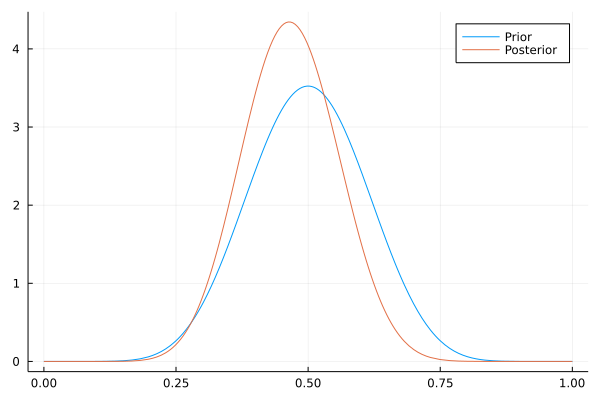

In [60]:
# Show our prior and posterior
prior_dist = Beta(α0, β0)
posterior_dist = Beta(α, β)
# Plot it
plot(prior_dist, label="Prior")
plot!(posterior_dist, label="Posterior")

Since we're all Bayesians now, we should know that, as we get more data, we become more confident about our beliefs.

Let's try playing this coin flip game a lot to see what happens to our posterior.

In [76]:
# Posterior density function
function posterior_coinflip(α0, β0, x)
    α = α0 + sum(x)
    β = β0 + length(x) - sum(x)
    return α, β
end

posteriors = Distribution[]
plt = plot(prior_dist, label="Prior")
data_counts = [1, 10, 100, 1_000, 10_000, 100_000]
for n_data in data_counts
    data = rand(Binomial(1, true_prob), n_data)
    α, β = posterior_coinflip(α0, β0, data)
    post_dist = Beta(α, β)
    push!(posteriors, post_dist)
    plot!(post_dist, label="Posterior (n=$n_data)")    
end

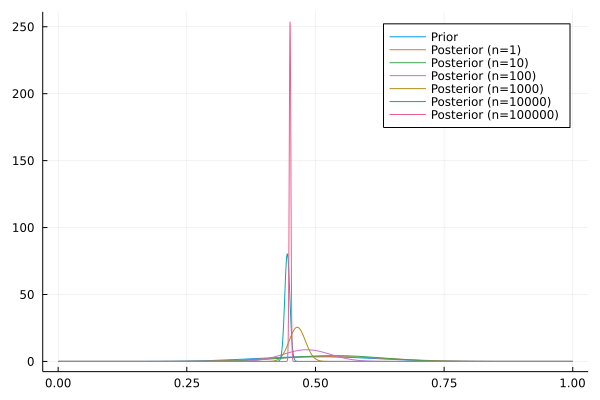

In [77]:
display(plt)

We can also see what happens to the mean and variance of $p$ as we increase the data.

In [81]:
using DataFrames

summary_stats = DataFrame(
    n_trials = data_counts,
    true_prob=true_prob,
    mean = mean.(posteriors),
    var = var.(posteriors),
    alpha = map(x -> x.α, posteriors),
    beta = map(x -> x.β, posteriors),
    p05 = quantile.(posteriors, [0.05]),
    p95 = quantile.(posteriors, [0.95]),
);

In [82]:
display(summary_stats)

,n_trials,true_prob,mean,var,alpha,beta,p05,p95
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,0.45,0.52381,0.0113379,11.0,10.0,0.346931,0.698046
2,10,0.45,0.533333,0.00802867,16.0,14.0,0.384392,0.679704
3,100,0.45,0.483333,0.00206382,58.0,62.0,0.408724,0.558259
4,1000,0.45,0.464706,0.000243638,474.0,546.0,0.439069,0.490421
5,10000,0.45,0.445309,2.46491e-5,4462.0,5558.0,0.437149,0.453482
6,100000,0.45,0.45068,2.47516e-6,45077.0,54943.0,0.448093,0.453268


### Practice problem

